In [1]:
!pip install datasets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 480.6/480.6 kB 23.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 179.3/179.3 kB 14.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 11.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 16.7 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2024.10.0
    Uninstalling fsspec-2024.10.0:
      Successfully uninstalled fsspec-2024.10.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gcsfs 2024.10.0 requires fsspec==2024.10.0, but you have fsspec 2024.9.0 which is incompatible.


In [2]:
from transformers import DebertaV2Tokenizer, DebertaV2ForSequenceClassification, Trainer, TrainingArguments
from sklearn.model_selection import train_test_split
from datasets import Dataset
import pandas as pd
import torch

# 모델 및 토크나이저 로드
model_name = "microsoft/deberta-v3-base"  # DeBERTa 모델
tokenizer = DebertaV2Tokenizer.from_pretrained(model_name)
model = DebertaV2ForSequenceClassification.from_pretrained(model_name, num_labels=2)

# 데이터 전처리 함수 정의
def preprocess_text(text):
    return tokenizer(text, truncation=True, padding="max_length", max_length=128)

# 데이터셋 로드 및 전처리
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

# 데이터셋 분리
train_texts, val_texts, train_labels, val_labels = train_test_split(
    train_data['text'], train_data['target'], test_size=0.2, random_state=42
)

# 토큰화 및 변환
train_encodings = tokenizer(list(train_texts), truncation=True, padding=True, max_length=128)
val_encodings = tokenizer(list(val_texts), truncation=True, padding=True, max_length=128)

# Hugging Face 데이터셋 포맷으로 변환
train_dataset = Dataset.from_dict({
    'input_ids': train_encodings['input_ids'],
    'attention_mask': train_encodings['attention_mask'],
    'labels': list(train_labels)
})
val_dataset = Dataset.from_dict({
    'input_ids': val_encodings['input_ids'],
    'attention_mask': val_encodings['attention_mask'],
    'labels': list(val_labels)
})

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

spm.model:   0%|          | 0.00/2.46M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/579 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/371M [00:00<?, ?B/s]

Some weights of DebertaV2ForSequenceClassification were not initialized from the model checkpoint at microsoft/deberta-v3-base and are newly initialized: ['classifier.bias', 'classifier.weight', 'pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [3]:
# 학습 설정
training_args = TrainingArguments(
    output_dir="./results",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    num_train_epochs=2,
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    logging_dir="./logs",
    logging_steps=10,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    save_total_limit=1,
    report_to="none"
)

# 평가 메트릭 함수 정의
def compute_metrics(pred):
    logits, labels = pred
    predictions = torch.argmax(torch.tensor(logits), axis=1)
    accuracy = (predictions == torch.tensor(labels)).float().mean()
    return {"accuracy": accuracy.item()}

# Trainer 설정
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

# 모델 학습
trainer.train()

# 검증 데이터 예측
results = trainer.evaluate()
print("Validation Accuracy:", results["eval_accuracy"])

# 테스트 데이터 예측 및 제출 파일 생성
test_encodings = tokenizer(list(test_data['text']), truncation=True, padding=True, max_length=128)
test_dataset = Dataset.from_dict({
    'input_ids': test_encodings['input_ids'],
    'attention_mask': test_encodings['attention_mask']
})

# 예측
predictions = trainer.predict(test_dataset)
test_data['target'] = torch.argmax(torch.tensor(predictions.predictions), axis=1).numpy()

# 제출 파일 생성
submission = test_data[['id', 'target']]
submission.to_csv('submission_v5_DeBERTa_GridSearch.csv', index=False)
print("Submission file saved as 'submission.csv'")

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1568: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
<ipython-input-3-b1bd3b5e176a>:26: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Trainer.__init__`. Use `processing_class` instead.
  trainer = Trainer(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.424100,0.381474,0.843729
2,0.352300,0.455652,0.841103


Validation Accuracy: 0.8437294960021973
Submission file saved as 'submission.csv'


Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


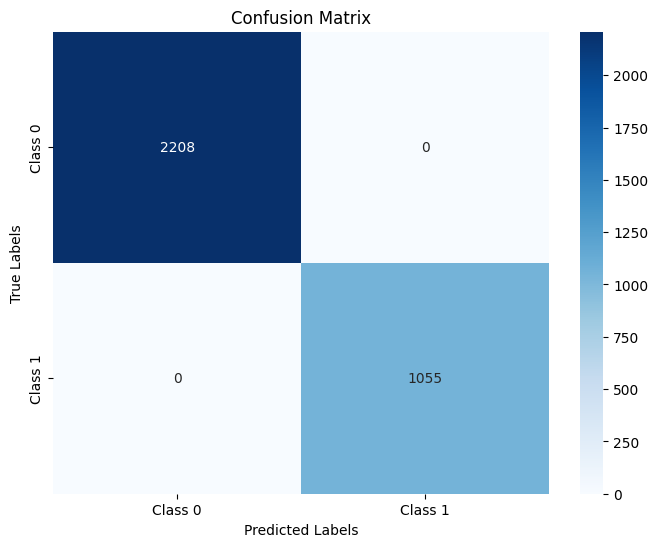

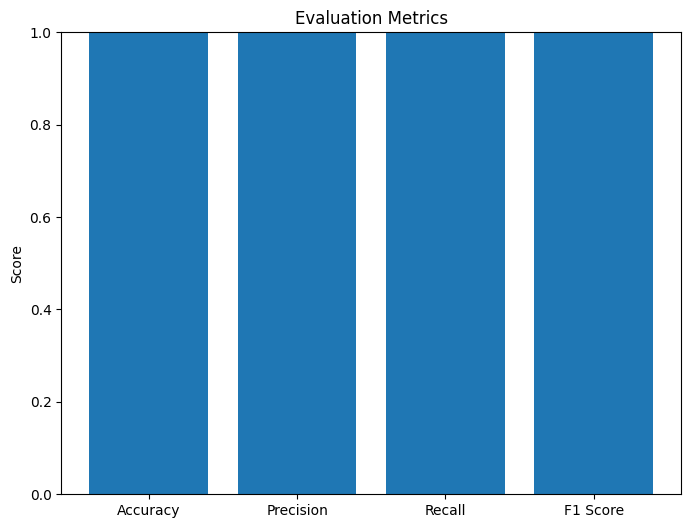

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score

# 예측값 및 실제값
logits = predictions.predictions
true_labels = test_data['target'].values  # Replace with actual test labels if available
predicted_labels = torch.argmax(torch.tensor(logits), axis=1).numpy()

# 혼동행렬 계산
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# 평가 메트릭 계산
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="binary")
recall = recall_score(true_labels, predicted_labels, average="binary")
f1 = f1_score(true_labels, predicted_labels, average="binary")

# 평가 메트릭 출력
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)

# 혼동행렬 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()

# 평가 메트릭 시각화
metrics = {"Accuracy": accuracy, "Precision": precision, "Recall": recall, "F1 Score": f1}
plt.figure(figsize=(8, 6))
plt.bar(metrics.keys(), metrics.values())
plt.ylim(0, 1)
plt.title("Evaluation Metrics")
plt.ylabel("Score")
plt.show()


In [5]:
# 실제 레이블과 예측값 확인
assert len(true_labels) == len(predicted_labels), "True labels and predictions length mismatch!"
print("Sample True Labels:", true_labels[:10])
print("Sample Predicted Labels:", predicted_labels[:10])

# 평가 메트릭 다시 계산
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average="binary")
recall = recall_score(true_labels, predicted_labels, average="binary")
f1 = f1_score(true_labels, predicted_labels, average="binary")

# 결과 출력
print("Re-calculated Metrics:")
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)


Sample True Labels: [1 1 1 1 1 1 0 0 0 0]
Sample Predicted Labels: [1 1 1 1 1 1 0 0 0 0]
Re-calculated Metrics:
Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1 Score: 1.0


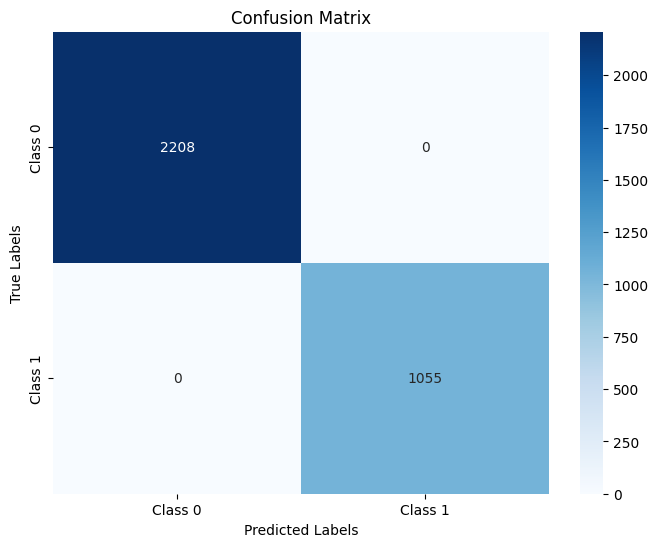

In [6]:
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", xticklabels=["Class 0", "Class 1"], yticklabels=["Class 0", "Class 1"])
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
